In [1]:
import numpy as np
import torch


import json
from torch.utils.data import DataLoader
from torch.optim import SGD, AdamW
from torch import nn

In [2]:
import utils_generic as generic
import rrnn_st as rrnn
import model_confs as confs
import singletask_dep as st

import train_dep as train

from gensim.models import KeyedVectors

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
torch.manual_seed(27)
word2vec_path = r"C:\Users\FarinhOso\gensim-data\word2vec-google-news-300\word2vec-google-news-300.gz"
word2vec_model =  KeyedVectors.load_word2vec_format(word2vec_path, binary=True)
encoding_type = 'brk'

# Datos ConvAI2

In [4]:
with open('Datasets\ConvAI2\convai2_complete.json','r') as f:
    data = json.load(f)

In [5]:
convai_train = data['train']
convai_val = data['validation']


vocab = st.Vocabulary(data['train'],encoding_type)
word_to_index = word2vec_model.key_to_index

convai_train_token = generic.tokenize_dataset_with_dependencies_rrnn(convai_train,['about','to','as'],vocab,word_to_index) 
convai_val_token = generic.tokenize_dataset_with_dependencies_rrnn(convai_val,['about','to','as'],vocab,word_to_index) 

In [6]:
convai_train_dataset = {}
for task in ['to','as','about']:
    convai_train_dataset[task] = rrnn.DatasetSingleTaskSimple(convai_train_token,task,eval=False,deps=True)

In [7]:
convai_val_dataset = {}
for task in ['to','as','about']:
    convai_val_dataset[task] = rrnn.DatasetSingleTaskSimple(convai_val_token,task,eval=False,deps=True)

# Datos md_gender

In [8]:
with open('Datasets\md_gender\md_complete.json','r',encoding="utf8") as f:
    md_data = json.load(f)

In [9]:
md_tokenized = generic.tokenize_dataset_with_dependencies_rrnn(md_data,['about','to','as'],vocab,word_to_index) 


md_dataset = {}
for task in ['to','as','about']:
    md_dataset[task] = rrnn.DatasetSingleTaskSimple(md_tokenized,task,eval=True,deps=True)

# Creación dataloaders

In [10]:
dl_train = {}
for task in ['to','as','about']:
    dl_train[task] = DataLoader(convai_train_dataset[task],batch_size=128,shuffle=True,collate_fn=rrnn.collate_fn_dep)

In [11]:
dl_val = {}
for task in ['to','as','about']:
    dl_val[task] = DataLoader(convai_val_dataset[task],batch_size=128,shuffle=True,collate_fn=rrnn.collate_fn_dep)

In [12]:
dl_eval = {}
for task in ['to','as','about']:
    dl_eval[task] = DataLoader(md_dataset[task],batch_size=128,shuffle=False,collate_fn=rrnn.collate_fn_dep)

# ABOUT

In [14]:
emb_dim = 20
vocab_size = len(word_to_index)
num_labels = 2
lstm_hidden_dim = 128

In [15]:
model = rrnn.SingleTaskRRNNDep(emb_dim,vocab,vocab_size,lstm_hidden_dim,emb_weights=word2vec_model.vectors).to(device)
save_path='m1_rrnn_dep_about_w2v'

In [16]:
for task in ['about','to','as']:
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}",'\n')
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

GLOBAL: 0.5127551020408163 

Using scikit learn accuracy por género en el conjunto about
MALE 0.010416666666666666
FEMALE 0.995 

GLOBAL: 0.48863636363636365 

Using scikit learn accuracy por género en el conjunto to
MALE 0.014598540145985401
FEMALE 1.0 

GLOBAL: 0.48239895697522817 

Using scikit learn accuracy por género en el conjunto as
MALE 0.015151515151515152
FEMALE 0.9811320754716981 



  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6929611402729247 	 Validation loss: 0.6908340050002276 	 
  1%|          | 574/57400 [00:11<09:08, 103.60it/s]
Epoch 2 	 Training loss: 0.6889936653994517 	 Validation loss: 0.6881104677410449 	 
  2%|▏         | 1148/57400 [00:22<09:24, 99.61it/s]
Epoch 3 	 Training loss: 0.6863900018070633 	 Validation loss: 0.6864522836976132 	 
  3%|▎         | 1722/57400 [00:34<09:13, 100.51it/s]
Epoch 4 	 Training loss: 0.6846593598663184 	 Validation loss: 0.6852562377008341 	 
  4%|▍         | 2296/57400 [00:45<09:34, 95.99it/s]
Epoch 5 	 Training loss: 0.6834898479931861 	 Validation loss: 0.6846452294769934 	 
  5%|▌         | 2870/57400 [00:56<09:21, 97.08it/s]
Epoch 6 	 Training loss: 0.6827353696997572 	 Validation loss: 0.6842115773993024 	 
  6%|▌         | 3444/57400 [01:08<09:36, 93.66it/s]
Epoch 7 	 Training loss: 0.6822166651591192 	 Validation loss: 0.6841062277050342 	 
  7%|▋         | 4018/57400 [01:19<08:52, 100.16it/s]
Epoch 8 	 Training loss: 0.68186

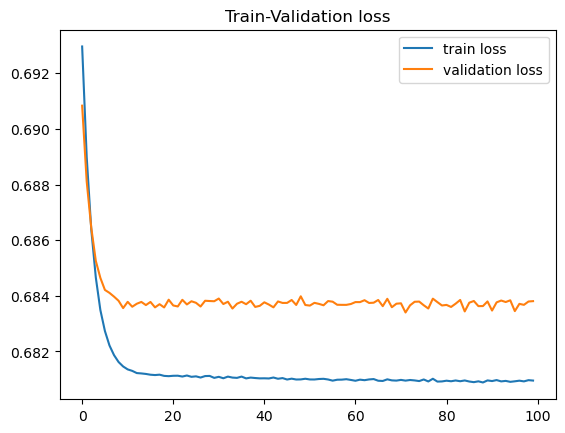

In [17]:
learning_rate = 5e-5
optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9)
num_epochs = 100

train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path)

In [17]:
del model
torch.cuda.empty_cache() 

In [16]:
model = rrnn.SingleTaskRRNNDep(emb_dim,vocab,vocab_size,lstm_hidden_dim,emb_weights=word2vec_model.vectors).to(device)
model.load_state_dict(torch.load('m1_rrnn_dep_about_w2v'))

for task in ['about','to','as']:
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}",'\n')
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

GLOBAL: 0.4897959183673469 

Using scikit learn accuracy por género en el conjunto about
MALE 1.0
FEMALE 0.0 

GLOBAL: 0.5189393939393939 

Using scikit learn accuracy por género en el conjunto to
MALE 1.0
FEMALE 0.0 

GLOBAL: 0.516297262059974 

Using scikit learn accuracy por género en el conjunto as
MALE 1.0
FEMALE 0.0 



# TO

In [ ]:
emb_dim = 20
vocab_size = len(word_to_index)
num_labels = 2
lstm_hidden_dim = 128

In [ ]:
model = rrnn.SingleTaskRRNN2(emb_dim,vocab_size,lstm_hidden_dim,emb_weights=word2vec_model.vectors).to(device)
save_path='m1_rrnn_dep_to_w2v'

In [ ]:
learning_rate = 5e-5
optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9)
num_epochs = 100

train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path)

In [ ]:
del model
torch.cuda.empty_cache() 

In [ ]:
model = rrnn.SingleTaskRRNN2(emb_dim,vocab_size,lstm_hidden_dim,emb_weights=word2vec_model.vectors).to(device)
model.load_state_dict(torch.load('m1_rrnn_simple_to_w2v'))

for task in ['about','to','as']:
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}",'\n')
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

# AS

In [ ]:
model = rrnn.SingleTaskRRNN2(emb_dim,vocab_size,lstm_hidden_dim,emb_weights=word2vec_model.vectors).to(device)
save_path='m1_rrnn_dep_as_w2v'

In [ ]:
learning_rate = 5e-5
optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9)
num_epochs = 100

train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path)

In [ ]:
del model
torch.cuda.empty_cache() 

In [ ]:
model = rrnn.SingleTaskRRNN2(emb_dim,vocab_size,lstm_hidden_dim,emb_weights=word2vec_model.vectors).to(device)
model.load_state_dict(torch.load(save_path))

for task in ['about','to','as']:
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}",'\n')
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

# AdamW

## ABOUT

In [20]:
model = rrnn.SingleTaskRRNNDep(emb_dim,vocab,vocab_size,lstm_hidden_dim,emb_weights=word2vec_model.vectors).to(device)
save_path='m1_rrnn_dep_about_adam_w2v'

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6180789686661564 	 Validation loss: 0.5300083407911204 	 
  1%|          | 574/57400 [00:13<11:50, 80.00it/s]
Epoch 2 	 Training loss: 0.4726200682672474 	 Validation loss: 0.44916815980006075 	 
  2%|▏         | 1148/57400 [00:25<12:00, 78.04it/s]
Epoch 3 	 Training loss: 0.446690633893013 	 Validation loss: 0.439537949986377 	 
  3%|▎         | 1722/57400 [00:38<12:59, 71.39it/s]
Epoch 4 	 Training loss: 0.43410542191944057 	 Validation loss: 0.4248960280822495 	 
  4%|▍         | 2296/57400 [00:51<13:13, 69.47it/s]
Epoch 5 	 Training loss: 0.42580637600571436 	 Validation loss: 0.4325853909476329 	 

1 epoch without improvement
  5%|▌         | 2870/57400 [00:59<12:52, 70.55it/s]
Epoch 6 	 Training loss: 0.41866456496590937 	 Validation loss: 0.4200895029609486 	 
  6%|▌         | 3444/57400 [01:11<11:37, 77.38it/s]
Epoch 7 	 Training loss: 0.4142865007451187 	 Validation loss: 0.4107803449792377 	 
  7%|▋         | 4018/57400 [01:24<12:08, 73.29it/s]
Epoc

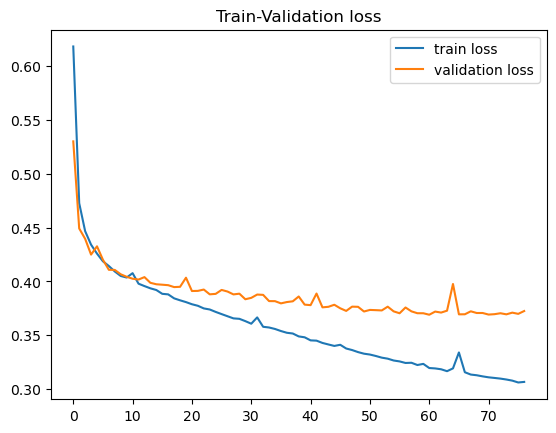

In [21]:
learning_rate = 5e-5
optimizer = AdamW(model.parameters(), lr=learning_rate)
num_epochs = 100

train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path)

In [17]:
del model
torch.cuda.empty_cache() 

In [16]:
model = rrnn.SingleTaskRRNNDep(emb_dim,vocab,vocab_size,lstm_hidden_dim,emb_weights=word2vec_model.vectors).to(device)
model.load_state_dict(torch.load('m1_rrnn_dep_about_adam_w2v'))

for task in ['about','to','as']:
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}",'\n')
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

GLOBAL: 0.8099489795918368 

Using scikit learn accuracy por género en el conjunto about
MALE 0.8411458333333334
FEMALE 0.78 

GLOBAL: 0.7032828282828283 

Using scikit learn accuracy por género en el conjunto to
MALE 0.7420924574209246
FEMALE 0.6614173228346457 

GLOBAL: 0.6936114732724902 

Using scikit learn accuracy por género en el conjunto as
MALE 0.7222222222222222
FEMALE 0.6630727762803235 



## TO

In [18]:
model = rrnn.SingleTaskRRNNDep(emb_dim,vocab,vocab_size,lstm_hidden_dim,emb_weights=word2vec_model.vectors).to(device)
save_path='m1_rrnn_dep_to_adam_w2v'

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6932515441748324 	 Validation loss: 0.6926658789990312 	 
  1%|          | 574/57400 [00:14<14:40, 64.52it/s]
Epoch 2 	 Training loss: 0.6931800435229045 	 Validation loss: 0.6917940448906462 	 
  2%|▏         | 1148/57400 [00:28<14:21, 65.29it/s]
Epoch 3 	 Training loss: 0.6931288875769239 	 Validation loss: 0.6943564505900367 	 

1 epoch without improvement
  3%|▎         | 1722/57400 [00:37<14:59, 61.88it/s]
Epoch 4 	 Training loss: 0.6931151151657104 	 Validation loss: 0.6935531345464415 	 

2 epoch without improvement
  4%|▍         | 2296/57400 [00:46<13:09, 69.79it/s]
Epoch 5 	 Training loss: 0.6930846390200824 	 Validation loss: 0.6920236035928888 	 
  5%|▌         | 2870/57400 [00:54<13:48, 65.80it/s]
Epoch 6 	 Training loss: 0.6929675687480886 	 Validation loss: 0.6927784418655654 	 
  6%|▌         | 3444/57400 [01:03<12:16, 73.30it/s]
Epoch 7 	 Training loss: 0.6929700497135468 	 Validation loss: 0.6925869119369378 	 
  7%|▋         | 4018/57400 [0

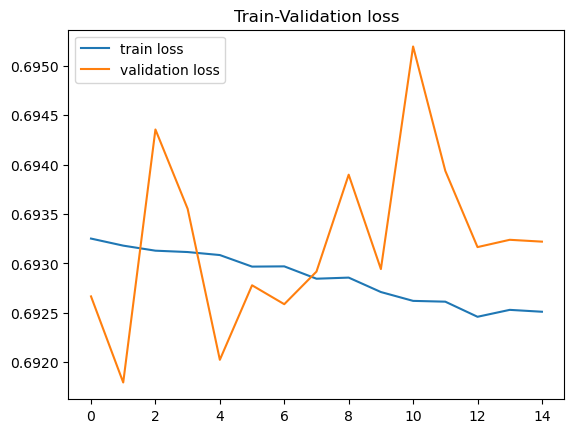

In [19]:
learning_rate = 5e-5
optimizer = AdamW(model.parameters(), lr=learning_rate)
num_epochs = 100

train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path)

In [20]:
del model
torch.cuda.empty_cache() 

In [21]:
model = rrnn.SingleTaskRRNNDep(emb_dim,vocab,vocab_size,lstm_hidden_dim,emb_weights=word2vec_model.vectors).to(device)
model.load_state_dict(torch.load(save_path))

for task in ['about','to','as']:
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}",'\n')
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

GLOBAL: 0.5165816326530612 

Using scikit learn accuracy por género en el conjunto about
MALE 0.018229166666666668
FEMALE 0.995 

GLOBAL: 0.48358585858585856 

Using scikit learn accuracy por género en el conjunto to
MALE 0.009732360097323601
FEMALE 0.994750656167979 

GLOBAL: 0.485006518904824 

Using scikit learn accuracy por género en el conjunto as
MALE 0.007575757575757576
FEMALE 0.9946091644204852 



## AS

In [22]:
model = rrnn.SingleTaskRRNNDep(emb_dim,vocab,vocab_size,lstm_hidden_dim,emb_weights=word2vec_model.vectors).to(device)
save_path='m1_rrnn_dep_as_adam_w2v'

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6932432198773694 	 Validation loss: 0.6923362572314375 	 
  1%|          | 574/57400 [00:13<13:56, 67.95it/s]
Epoch 2 	 Training loss: 0.6931436141816582 	 Validation loss: 0.6935423612594604 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [00:22<15:25, 60.77it/s]
Epoch 3 	 Training loss: 0.6926809089316723 	 Validation loss: 0.6932477284285982 	 
  3%|▎         | 1722/57400 [00:31<13:47, 67.30it/s]
Epoch 4 	 Training loss: 0.6913794442128637 	 Validation loss: 0.6909625186758527 	 
  4%|▍         | 2296/57400 [00:45<13:46, 66.64it/s]
Epoch 5 	 Training loss: 0.6895828042503849 	 Validation loss: 0.691730433601444 	 
  5%|▌         | 2870/57400 [00:54<14:58, 60.70it/s]
Epoch 6 	 Training loss: 0.6882358340851521 	 Validation loss: 0.6916776218656766 	 
  6%|▌         | 3444/57400 [01:03<14:40, 61.31it/s]
Epoch 7 	 Training loss: 0.6883869037187889 	 Validation loss: 0.6912338976132668 	 
  7%|▋         | 4018/57400 [01:12<12:32, 70.98it/s]
Epoch 8

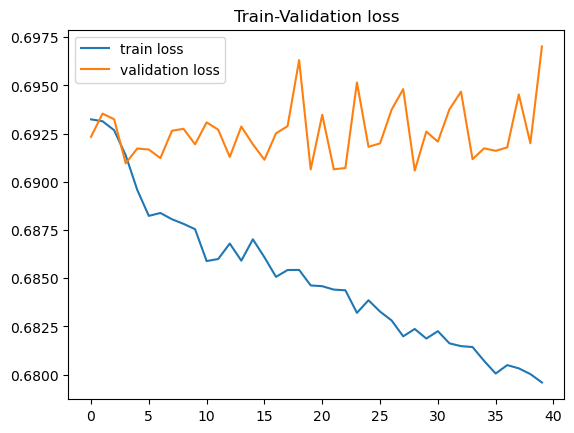

In [23]:
learning_rate = 5e-5
optimizer = AdamW(model.parameters(), lr=learning_rate)
num_epochs = 100

train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path)

In [ ]:
del model
torch.cuda.empty_cache() 

In [15]:
model = rrnn.SingleTaskRRNNDep(emb_dim,vocab,vocab_size,lstm_hidden_dim,emb_weights=word2vec_model.vectors).to(device)
save_path='m1_rrnn_dep_as_adam_w2v'
model.load_state_dict(torch.load(save_path))

for task in ['about','to','as']:
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}",'\n')
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

GLOBAL: 0.7168367346938775 

Using scikit learn accuracy por género en el conjunto about
MALE 0.5651041666666666
FEMALE 0.8625 

GLOBAL: 0.6603535353535354 

Using scikit learn accuracy por género en el conjunto to
MALE 0.559610705596107
FEMALE 0.7690288713910761 

GLOBAL: 0.6870925684485006 

Using scikit learn accuracy por género en el conjunto as
MALE 0.5050505050505051
FEMALE 0.8814016172506739 

